In [1]:

import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import nltk
conn = mysql.connector.connect(
    host='127.0.0.1',         
    user='root',
    password='weichi021021',
    database='yelp'  
)
# Define the SQL query to get the average review stars for Beauty & Spas businesses
query = """
SELECT 
    r.text
FROM yelp_business b
JOIN yelp_review r ON b.business_id = r.business_id
WHERE b.name in (
    'Shimmer Nails and Hair',
    'Liquid Glam Nail Bar',
    'Sapphire Nails and Spa',
    'Lavish Nail Lounge'
)
  AND b.state IN ('NV')
"""
df = pd.read_sql(query, conn)
df.to_csv('/Users/weichi/Desktop/beauty_spas_monthly_reviews7.csv', index=False)

conn.close()


/var/folders/76/fkxy076d3292blk3kfnwtddh0000gn/T/ipykernel_85130/266455429.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [2]:
from transformers import pipeline
import csv
import numpy as np
from bertopic import BERTopic
reviews = []
with open('/Users/weichi/Desktop/beauty_spas_monthly_reviews5.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) 
    for row in reader:
        reviews.append(row[0])

/Users/weichi/virtualenv_name/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/weichi/virtualenv_name/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
texts = reviews[:2000] 
results = classifier(texts, truncation=True, batch_size=16)
positive = []
negative = []
for text, res in zip(texts, results):
    if res['label'] == 'POSITIVE':
        positive.append(text)
    else:
        negative.append(text)


Device set to use mps:0


In [4]:
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)
lower_cleaned = [clean_text(review) for review in positive]
lower_cleaned2 = [clean_text(review) for review in negative]




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/weichi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
count = 0
for i in reviews:
        if 'mixologist' in i:
            count += 1
print(count)
        

1


I am so happy I stopped in here randomly one night to get a quick mani! As soon as I walked in I saw a familiar face and knew I was "home". All of the nail techs are friendly, fun, talented, and experienced here! An always takes amazing care of me and my terrible nails! Being a mixologist really will do a number on your hands but they always look AMAZING once An works her magic! They have a large selection of colors as well. This is a newer shop and everything is kept immaculate. I know they will thrive here in the south west! Their pride for their work and their talent speaks for itself. You have to go in and check them out!

In [6]:
import spacy 
nlp = spacy.load('en_core_web_sm')



{'organic': 148, 'great': 700, 'good': 519, 'amazing': 402, 'friendly': 300, 'clean': 296, 'nice': 267, 'new': 224, 'happy': 202, 'sure': 135, 'professional': 125, 'beautiful': 125, 'awesome': 119, 'wonderful': 112, 'recommend': 95, 'perfect': 88, 'excellent': 86, 'able': 84, 'sweet': 78, 'long': 77, 'comfortable': 77, 'little': 74, 'regular': 72, 'busy': 71, 'worth': 66, 'right': 65, 'reasonable': 63, 'polite': 61, 'thorough': 56, 'different': 56, 'glad': 55, 'hot': 49, 'fantastic': 49, 'favorite': 48, 'bad': 47, 'melissa': 46, 'old': 45, 'fabulous': 44, 'quick': 42, 'previous': 42, 'attentive': 41, 'close': 41, 'satisfied': 41, 'soft': 39, 'cute': 39, 'hard': 38, 'extra': 38, 'late': 38, 'second': 37, 'natural': 37, 'sns': 36, 'fast': 35, 'dry': 35, 'well': 35, 'easy': 34, 'gentle': 33, 'overall': 33, 'horrible': 32, 'ill': 32, 'warm': 31, 'gorgeous': 31, 'available': 31, 'super': 31, 'pleasant': 30, 'straight': 30, 'particular': 30, 'small': 30, 'precise': 29, 'open': 29, 'technicia

Text(0.5, 1.0, 'Positive Words from Reviews')

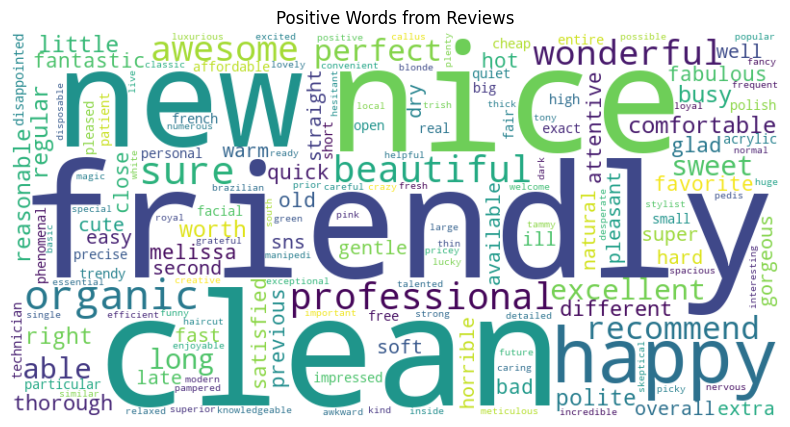

In [9]:
from wordcloud import WordCloud
from umap.umap_ import UMAP
adjectives = []
nouns = []
docs = list(nlp.pipe(lower_cleaned[:2000]))
for doc in docs:
    for token in doc:
        if token.pos_ == 'ADJ' and not token.is_stop and len(token.text) > 2:
            adjectives.append(token.lemma_.lower())
        elif token.pos_ in ['NOUN', 'PROPN'] and not token.is_stop and len(token.text) > 2:
            nouns.append(token.lemma_.lower())
umap_model = UMAP(random_state=10)  # fixed seed for reproducibility
topic_model = BERTopic(umap_model=umap_model)
topics, probs = topic_model.fit_transform(adjectives)
topic_info = topic_model.get_topic_info()

# Extract the first keyword (after topic number)
topic_info['first_word'] = topic_info['Name'].apply(lambda x: x.split('_')[1] if '_' in x else None)

# Select relevant columns
keyword_dict = dict(
    topic_info.apply(lambda row: (row['Name'].split('_')[1], row['Count']), axis=1)
)
keyword_dict = word_freq_cleaned = {v[0]: v[1] for v in keyword_dict.values()}
print(keyword_dict)
del keyword_dict['great']
del keyword_dict['good']
del keyword_dict['amazing']
del keyword_dict['nude']
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_dict)

# Plot it
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words from Reviews')


    Topic  Count                                           Name  \
0      -1    493              -1_certificate_peel_jayden_studio   
1       0   1249                    0_nail_nails_streaky_streak   
2       1    455                1_time_late_everytime_timesleft   
3       2    324     2_pedicure_manucure_pedicurist_pedicuremay   
4       3    317                       3_place_position_park_in   
5       4    303                   4_gel_biogel_wgel_usedactive   
6       5    277                            5_salon_salonjust__   
7       6    277               6_service_services_server_system   
8       7    215  7_manicure_manicurepedicure_scratch_manicures   
9       8    194                                8_day_daysand__   
10      9    183                           9_polish_polishing__   
11     10    180                                 10_customer___   
12     11    178   11_appointment_consultation_consulter_clinic   
13     12    171                      12_color_white_purple_dy

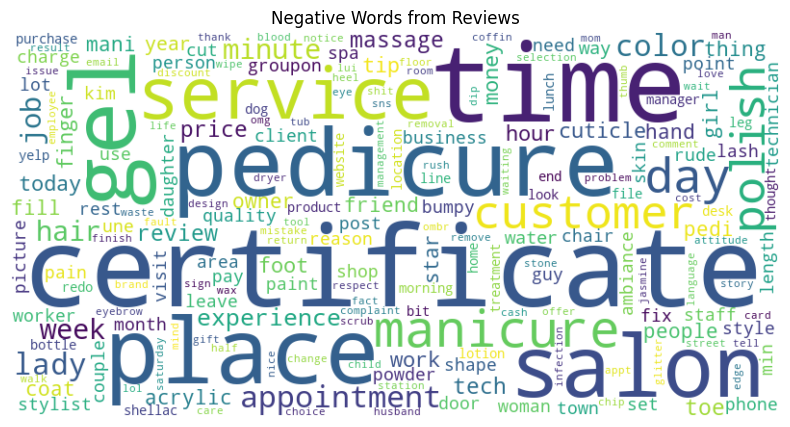

In [ ]:
docs1 = list(nlp.pipe(lower_cleaned2[:2000]))
adjectives2 = []
nouns2 = []
for doc in docs1:
    for token in doc:
        if token.pos_ == 'ADJ' and not token.is_stop and len(token.text) > 2:
            adjectives2.append(token.lemma_.lower())
        elif token.pos_ in ['NOUN', 'PROPN'] and not token.is_stop and len(token.text) > 2:
            nouns2.append(token.lemma_.lower())
umap_model = UMAP(random_state=10)  # fixed seed for reproducibility
topic_model = BERTopic(umap_model=umap_model)
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(nouns2)
topic_info = topic_model.get_topic_info()
print(topic_info[:20])
keyword_dict2 = dict(
    topic_info.apply(lambda row: (row['Name'].split('_')[1], row['Count']), axis=1)
)
keyword_dict2 = word_freq_cleaned = {v[0]: v[1] for v in keyword_dict2.values()}
del keyword_dict2['nail']
del keyword_dict2['foil']

wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_dict2)
# Plot it
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words from Reviews')
plt.show()


In [13]:
import pandas as pd
reviews2 = []
df = pd.read_csv('/Users/weichi/Desktop/beauty_spas_monthly_reviews6.csv')
summary = df.groupby('name').agg({
    'review_count': 'sum',
    'avg_rating': 'mean'
}).sort_values(by='review_count', ascending=False)

print(summary.head(10))  


                        review_count  avg_rating
name                                            
"Diamond Nails & Spa"            622    4.136829
"Polished Nails & Spa"           508    3.191023
"Elaine's Nails"                 463    4.400615
"LOOK Style Society"             376    4.318750
"The Nail Bar"                   370    4.128364
"Pink Nails"                     370    3.123028
"Nailed and Lashed"              352    3.684694
"FINO for MEN"                   351    4.706071
"702 Nail Lounge"                346    4.394054
"Bombshell Nail & Spa"           341    3.963846


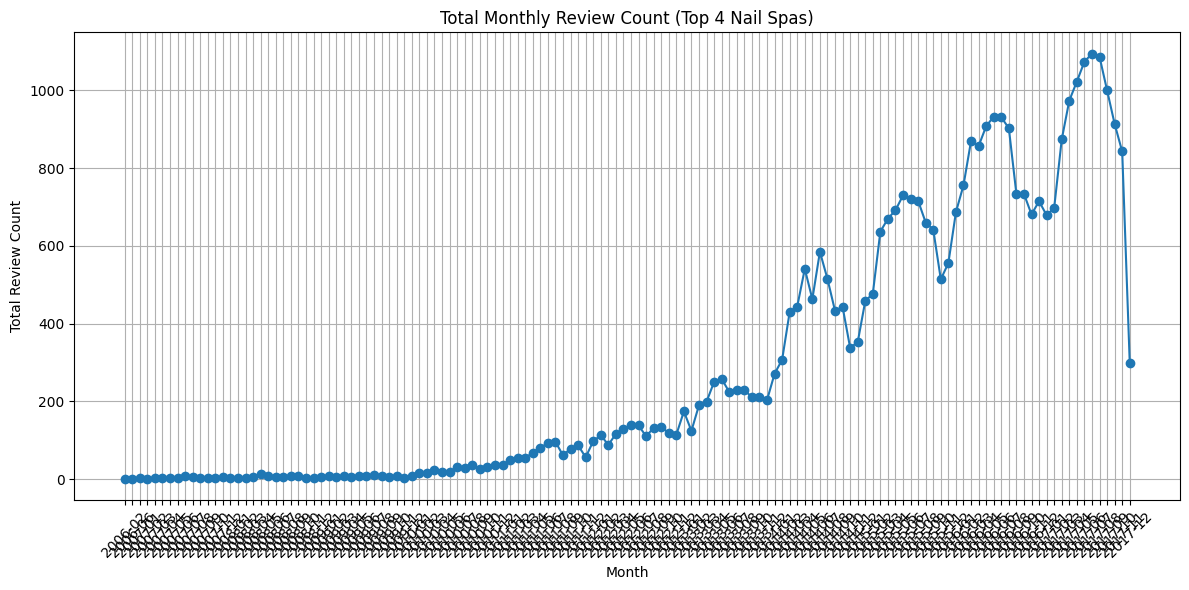

In [14]:
# Step 1: Get top 4 business names by total review count
summary = df.groupby('name')['review_count'].sum().sort_values(ascending=False).reset_index()
top_names = summary['name'].tolist()

# Step 2: Filter to only those businesses
df_filtered = df[df['name'].isin(top_names)]

# Step 3: Group by month and sum review_count
monthly_total = df_filtered.groupby('month')['review_count'].sum().reset_index()

# Step 4: Plot total reviews per month
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_total['month'], monthly_total['review_count'], marker='o')

plt.title('Total Monthly Review Count (Top 4 Nail Spas)')
plt.xlabel('Month')
plt.ylabel('Total Review Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
df['month'] = pd.to_datetime(df['month'])

# Earliest month each business appears
first_seen = df.groupby('name')['month'].min().reset_index()
first_seen.columns = ['name', 'first_month']

# Merge with overall review stats
recent_df = df.merge(first_seen, on='name')

# Filter businesses that appeared after 2015
emerging = recent_df[recent_df['first_month'] >= '2016-01-01']
# Calculate total reviews per business
total_reviews = emerging.groupby('name')['review_count'].sum().reset_index()

# Calculate average monthly review count (as a proxy for momentum)
monthly_avg = emerging.groupby('name')['review_count'].mean().reset_index()
monthly_avg.columns = ['name', 'monthly_avg']

# Merge
growth_df = total_reviews.merge(monthly_avg, on='name').sort_values(by='monthly_avg', ascending=False)

print(growth_df.head(10))  # Top emerging fast-growers



                                 name  review_count  monthly_avg
114          "Shimmer Nails and Hair"           256    11.130435
56             "Liquid Glam Nail Bar"            87     7.909091
111          "Sapphire Nails and Spa"            47     7.833333
53               "Lavish Nail Lounge"           139     7.722222
92   "Nevada Nails Spa & Lash Studio"            73     7.300000
75                     "Nail Society"            57     7.125000
130                  "The Studio Hue"             7     7.000000
99                "Paris nail Lounge"            14     7.000000
143                  "iNails and Spa"            21     7.000000
117                 "Social Nail Bar"            54     6.750000


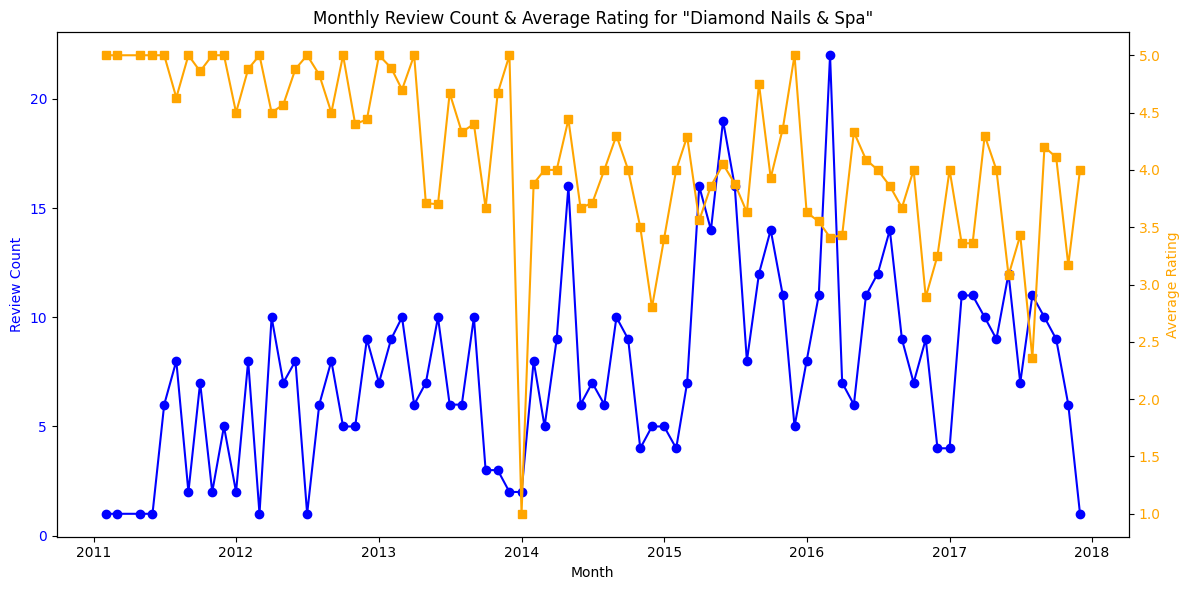

In [17]:
summary = df.groupby('name')['review_count'].sum().sort_values(ascending=False)
top_names = summary.head(5).index.tolist()

# Step 2: Pick the top one
top_business = top_names[0]  # You can also loop through top_names for multiple plots

# Step 3: Filter data for the top business
top_df = df[df['name'] == top_business].sort_values('month')

# Step 4: Create the dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis: review count
ax1.set_title(f'Monthly Review Count & Average Rating for {top_business}')
ax1.plot(top_df['month'], top_df['review_count'], color='blue', label='Review Count', marker='o')
ax1.set_xlabel('Month')
ax1.set_ylabel('Review Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Right y-axis: average rating
ax2 = ax1.twinx()
ax2.plot(top_df['month'], top_df['avg_rating'], color='orange', label='Avg Rating', marker='s')
ax2.set_ylabel('Average Rating', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Formatting
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

In [ ]:
df['month'] = pd.to_datetime(df['month'])
first_appearance = df.groupby('name')['month'].min().reset_index()
recent_businesses = first_appearance[first_appearance['month'] >= '2016-01-01']
adjectives3 = []
nouns3 = []
# Merge with df to see reviews
df['sample_review']
docs = list(nlp.pipe((df['sample_review'].tolist())[:2000]))
for doc in docs1:
    for token in doc:
        if token.pos_ == 'ADJ' and not token.is_stop and len(token.text) > 2:
            adjectives3.append(token.lemma_.lower())
        elif token.pos_ in ['NOUN', 'PROPN'] and not token.is_stop and len(token.text) > 2:
            nouns3.append(token.lemma_.lower())
umap_model = UMAP(random_state=10)  # fixed seed for reproducibility
topic_model = BERTopic(umap_model=umap_model)
topics, probs = topic_model.fit_transform(nouns3)
topic_info = topic_model.get_topic_info()
print(topic_info[:20])



    Topic  Count                                           Name  \
0      -1    582               -1_callus_lunch_brand_difference   
1       0   1250                    0_nail_nails_streaky_streak   
2       1    457                1_time_late_everytime_timesleft   
3       2    326                 2_place_position_park_facility   
4       3    320  3_pedicure_pedicurist_pedicuremay_pedicureand   
5       4    298                         4_gel_biogel_wgel_scab   
6       5    277                            5_salon_salonjust__   
7       6    274            6_service_services_system_servicing   
8       7    216  7_manicure_manicurepedicure_scratch_manicures   
9       8    194                                8_day_daysand__   
10      9    185            9_polish_polishing_tomato_caucasian   
11     10    184   10_appointment_meeting_referral_consultation   
12     11    182                     11_customer_snl_bartender_   
13     12    176                      12_color_white_purple_dy

In [ ]:

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Step 0: Load your data
df = pd.read_csv('/Users/weichi/Desktop/beauty_spas_monthly_reviews6.csv')
df['month'] = pd.to_datetime(df['month'])

# -----------------------------
# Step 1: Compute Review Growth (slope over time)
# -----------------------------
def compute_growth(business_df):
    business_df = business_df.sort_values('month')
    x = np.arange(len(business_df)).reshape(-1, 1)
    y = business_df['review_count'].values.reshape(-1, 1)
    if len(x) > 1:
        model = LinearRegression().fit(x, y)
        return model.coef_[0][0]
    else:
        return 0

growth = df.groupby('name').apply(compute_growth).reset_index()
growth.columns = ['name', 'growth']

# -----------------------------
# Step 2: Placeholder for Sentiment (set to 0.0)
# -----------------------------
df['sentiment'] = 0.0
sentiment = df.groupby('name')['sentiment'].mean().reset_index()

# -----------------------------
# Step 3: Compute Total Review Volume and Avg Rating
# -----------------------------
volume = df.groupby('name')['review_count'].sum().reset_index()
avg_rating = df.groupby('name')['avg_rating'].mean().reset_index()

# -----------------------------
# Step 4: Compute Loyalty Score (active months with ≥ 2 reviews)
# -----------------------------
active_months = df.groupby('name')['month'].nunique().reset_index()
loyal_months = df[df['review_count'] >= 2].groupby('name')['month'].nunique().reset_index()

active_months.columns = ['name', 'total_months']
loyal_months.columns = ['name', 'loyal_months']

loyalty = pd.merge(active_months, loyal_months, on='name', how='left').fillna(0)
loyalty['loyalty_score'] = loyalty['loyal_months'] / loyalty['total_months']
loyalty = loyalty[['name', 'loyalty_score']]

# -----------------------------
# Step 5: Merge All Metrics
# -----------------------------
combined = (
    growth
    .merge(sentiment, on='name')
    .merge(volume, on='name')
    .merge(avg_rating, on='name')
    .merge(loyalty, on='name')
)

# -----------------------------
# Step 6: Normalize Each Metric (0–1 scale)
# -----------------------------
scaler = MinMaxScaler()
combined[['growth_norm', 'sentiment_norm', 'volume_norm', 'avg_rating_norm', 'loyalty_norm']] = scaler.fit_transform(
    combined[['growth', 'sentiment', 'review_count', 'avg_rating', 'loyalty_score']]
)

# -----------------------------
# Step 7: Weighted Scoring Formula
# -----------------------------
combined['final_score'] = (
    0.25 * combined['avg_rating_norm'] +
    0.25 * combined['growth_norm'] +
    0.20 * combined['volume_norm'] +
    0.20 * combined['sentiment_norm'] +  # currently 0s
    0.10 * combined['loyalty_norm']
)

# Sort by overall score
combined = combined.sort_values(by='final_score', ascending=False).reset_index(drop=True)
print(combined.head(10))  # Top 10 businesses



                    name    growth  sentiment  review_count  avg_rating  \
0  "Diamond Nails & Spa"  0.077666        0.0           622    4.136829   
1       "Elaine's Nails"  0.053715        0.0           463    4.400615   
2         "FINO for MEN"  0.087594        0.0           351    4.706071   
3      "702 Nail Lounge"  0.164296        0.0           346    4.394054   
4   "LOOK Style Society"  0.004823        0.0           376    4.318750   
5              "Nail 21"  2.800000        0.0            24    5.000000   
6             "KNC Skin"  2.000000        0.0            10    5.000000   
7         "The Nail Bar"  0.017749        0.0           370    4.128364   
8      "Luxury Thai Spa"  0.111726        0.0           231    4.675750   
9        "Lacquer Me Up"  0.228571        0.0           207    4.776857   

   loyalty_score  growth_norm  sentiment_norm  volume_norm  avg_rating_norm  \
0       0.914634     0.690644             0.0     1.000000         0.784207   
1       0.951613

/var/folders/76/fkxy076d3292blk3kfnwtddh0000gn/T/ipykernel_60348/3191284480.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  growth = df.groupby('name').apply(compute_growth).reset_index()


Looks like the one with the most reviews is not the one that started the earliest. At first the different companies have various amount of reviews. I think it means that the Diamond Nails did a better work or has more ppopularity for their products. But then in the beginning of 2016, the patterns of the top 3 companies started to match. and all the way to 2018, their rise and fall roughly at the same time. This could indicate saturation of the market and unification of companies as they might provide similar products or services. 